In [980]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, Activation
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn import metrics as ms
from tensorflow.keras import regularizers

from matplotlib import pyplot
from pickle import load

# X_train = np.load("./saveData/IBM/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/IBM/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/IBM/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/IBM/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/IBM/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/IBM/y_val.npy", allow_pickle=True)

X_train = np.load("./saveData/MSFT/X_train.npy", allow_pickle=True)
y_train = np.load("./saveData/MSFT/y_train.npy", allow_pickle=True)
X_test = np.load("./saveData/MSFT/X_test.npy", allow_pickle=True)
y_test = np.load("./saveData/MSFT/y_test.npy", allow_pickle=True)
X_val = np.load("./saveData/MSFT/X_val.npy", allow_pickle=True)
y_val = np.load("./saveData/MSFT/y_val.npy", allow_pickle=True)

# X_train = np.load("./saveData/TSLA/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/TSLA/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/TSLA/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/TSLA/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/TSLA/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/TSLA/y_val.npy", allow_pickle=True)

# X_train = np.load("./saveData/S&P500/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/S&P500/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/S&P500/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/S&P500/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/S&P500/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/S&P500/y_val.npy", allow_pickle=True)

# X_train = np.load("./saveData/PAICC/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/PAICC/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/PAICC/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/PAICC/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/PAICC/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/PAICC/y_val.npy", allow_pickle=True)

# X_train = np.load("./saveData/SSE/X_train.npy", allow_pickle=True)
# y_train = np.load("./saveData/SSE/y_train.npy", allow_pickle=True)
# X_test = np.load("./saveData/SSE/X_test.npy", allow_pickle=True)
# y_test = np.load("./saveData/SSE/y_test.npy", allow_pickle=True)
# X_val = np.load("./saveData/SSE/X_val.npy", allow_pickle=True)
# y_val = np.load("./saveData/SSE/y_val.npy", allow_pickle=True)

# yc_train = np.load("./saveData/yc_train.npy", allow_pickle=True)
# yc_test = np.load("./saveData/yc_test.npy", allow_pickle=True)

In [981]:
y_train

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [982]:
dict_count = {}
dict_count['跌']=0
dict_count['涨']=0
dict_count['平']=0
for i in range(len(y_train)):
    if(y_train[i][0] ==1):
        dict_count['跌'] += 1
    if(y_train[i][1] == 1):
        dict_count['平'] += 1
    if(y_train[i][2] == 1):
        dict_count['涨'] += 1

In [983]:
dict_count

{'跌': 1168, '涨': 1163, '平': 1519}

In [984]:
y_train.shape[1]

3

In [985]:
# X_train = X_train[0:5001]
# y_train = y_train[0:5001]
# X_test = X_test[0:5001]
# y_test = y_test[0:5001]
# X_val = X_val[0:5001]
# y_val = y_val[0:5001]

In [986]:
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Flatten, RepeatVector ,MaxPooling1D,Bidirectional

In [987]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
min_delta_val = 0.0001
lr_cb = ReduceLROnPlateau(monitor = 'accuracy',  
                          factor = 0.5, min_delta = min_delta_val, patience = 10, verbose = 1)
es_cb = EarlyStopping(monitor = 'accuracy', 
                      min_delta=min_delta_val, patience = 20, verbose = 1, restore_best_weights = True,mode='max')

callbacks_model = [lr_cb, es_cb]

In [988]:


#Parameters
LR = 0.001
BATCH_SIZE = 60
N_EPOCH = 1000
dropout = 0.2
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
#做3分类
output_dim = y_train.shape[1]

#output_dim = 3

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def basic_lstm(input_dim, feature_size):
    
    model = Sequential()
    model.add(GRU(units=64, return_sequences = True, input_shape=(input_dim, feature_size)))
    model.add(Dropout(dropout))
#     model.add(GRU(units=64, return_sequences = True, recurrent_dropout=dropout)) # 256, return_sequences = True
    model.add(GRU(units=32)) #, recurrent_dropout=0.1
    model.add(Dropout(dropout))
    # , recurrent_dropout = 0.2
    #model.add(Dense(32))
    #model.add(Dropout(dropout))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim,activation='softmax'))

    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = LR),metrics=METRICS)
#     model = Sequential()
#     model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
#     model.add(Dense(64))
#     model.add(Dense(units=output_dim,activation='softmax'))
#     model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),
                        verbose=1, shuffle=False, callbacks=callbacks_model)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return model,history





In [989]:
X_train.shape

(3850, 30, 16)

In [990]:
y_train.shape

(3850, 3)

In [991]:
X_val.shape

(372, 30, 16)

In [992]:
y_val.shape

(372, 3)

In [993]:
y_train

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [994]:
X_train


array([[[-0.54032378, -0.53686854, -0.5451729 , ..., -0.03347705,
         -0.19959115,  0.61017054],
        [-0.52286219, -0.51822295, -0.53392964, ...,  0.03873689,
         -0.29396024,  0.5838482 ],
        [-0.5431301 , -0.54619133, -0.54954527, ..., -0.04288333,
         -0.34417429,  0.61138383],
        ...,
        [-0.39283575, -0.38708234, -0.39510668, ...,  0.26057995,
         -0.21451709,  0.79072663],
        [-0.36227798, -0.36579529, -0.36278233, ...,  0.36242716,
         -0.21737169,  0.80622084],
        [-0.35354718, -0.35973548, -0.36528083, ...,  0.29062825,
         -0.20897412,  0.79079421]],

       [[-0.52286219, -0.51822295, -0.53392964, ...,  0.03873689,
         -0.29396024,  0.5838482 ],
        [-0.5431301 , -0.54619133, -0.54954527, ..., -0.04288333,
         -0.34417429,  0.61138383],
        [-0.5431301 , -0.55240652, -0.5501699 , ..., -0.07973812,
         -0.38798172,  0.58833682],
        ...,
        [-0.36227798, -0.36579529, -0.36278233, ...,  

Epoch 1/1000
65/65 [==============================] - 4s 59ms/step - loss: 1.1144 - tp: 503.0000 - fp: 672.0000 - tn: 7028.0000 - fn: 3347.0000 - accuracy: 0.4055 - precision: 0.4281 - recall: 0.1306 - auc: 0.5753 - prc: 0.3916 - val_loss: 1.1042 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 744.0000 - val_fn: 372.0000 - val_accuracy: 0.3280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4873 - val_prc: 0.3194
Epoch 2/1000
65/65 [==============================] - 2s 35ms/step - loss: 1.1045 - tp: 33.0000 - fp: 54.0000 - tn: 7646.0000 - fn: 3817.0000 - accuracy: 0.3673 - precision: 0.3793 - recall: 0.0086 - auc: 0.5273 - prc: 0.3576 - val_loss: 1.1121 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 744.0000 - val_fn: 372.0000 - val_accuracy: 0.3091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4862 - val_prc: 0.3264
Epoch 3/1000
65/65 [==============================] - 2s 31ms/step - loss: 1.1022 - tp: 1.0000 - fp: 2.0000 - tn: 7698.0000 

Epoch 19/1000
65/65 [==============================] - 2s 30ms/step - loss: 1.0837 - tp: 24.0000 - fp: 32.0000 - tn: 7668.0000 - fn: 3826.0000 - accuracy: 0.4026 - precision: 0.4286 - recall: 0.0062 - auc: 0.5751 - prc: 0.3960 - val_loss: 1.1009 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 744.0000 - val_fn: 372.0000 - val_accuracy: 0.3656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5268 - val_prc: 0.3614
Epoch 20/1000
65/65 [==============================] - 2s 29ms/step - loss: 1.0824 - tp: 25.0000 - fp: 33.0000 - tn: 7667.0000 - fn: 3825.0000 - accuracy: 0.4057 - precision: 0.4310 - recall: 0.0065 - auc: 0.5768 - prc: 0.3952 - val_loss: 1.1004 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 744.0000 - val_fn: 372.0000 - val_accuracy: 0.3360 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5290 - val_prc: 0.3632
Epoch 21/1000
65/65 [==============================] - 2s 30ms/step - loss: 1.0821 - tp: 24.0000 - fp: 43.0000 - tn: 7657.00

65/65 [==============================] - 2s 29ms/step - loss: 1.0436 - tp: 589.0000 - fp: 498.0000 - tn: 7202.0000 - fn: 3261.0000 - accuracy: 0.4618 - precision: 0.5419 - recall: 0.1530 - auc: 0.6400 - prc: 0.4641 - val_loss: 1.1332 - val_tp: 47.0000 - val_fp: 61.0000 - val_tn: 683.0000 - val_fn: 325.0000 - val_accuracy: 0.3468 - val_precision: 0.4352 - val_recall: 0.1263 - val_auc: 0.5453 - val_prc: 0.3724
Epoch 39/1000
65/65 [==============================] - 2s 29ms/step - loss: 1.0353 - tp: 645.0000 - fp: 468.0000 - tn: 7232.0000 - fn: 3205.0000 - accuracy: 0.4745 - precision: 0.5795 - recall: 0.1675 - auc: 0.6513 - prc: 0.4779 - val_loss: 1.1357 - val_tp: 48.0000 - val_fp: 65.0000 - val_tn: 679.0000 - val_fn: 324.0000 - val_accuracy: 0.3441 - val_precision: 0.4248 - val_recall: 0.1290 - val_auc: 0.5451 - val_prc: 0.3722
Epoch 40/1000
65/65 [==============================] - 2s 26ms/step - loss: 1.0392 - tp: 645.0000 - fp: 502.0000 - tn: 7198.0000 - fn: 3205.0000 - accuracy: 0.459

65/65 [==============================] - 2s 27ms/step - loss: 1.0166 - tp: 883.0000 - fp: 612.0000 - tn: 7088.0000 - fn: 2967.0000 - accuracy: 0.4886 - precision: 0.5906 - recall: 0.2294 - auc: 0.6712 - prc: 0.5042 - val_loss: 1.2095 - val_tp: 87.0000 - val_fp: 145.0000 - val_tn: 599.0000 - val_fn: 285.0000 - val_accuracy: 0.3575 - val_precision: 0.3750 - val_recall: 0.2339 - val_auc: 0.5251 - val_prc: 0.3617
Epoch 58/1000
65/65 [==============================] - 2s 31ms/step - loss: 1.0154 - tp: 833.0000 - fp: 608.0000 - tn: 7092.0000 - fn: 3017.0000 - accuracy: 0.4914 - precision: 0.5781 - recall: 0.2164 - auc: 0.6721 - prc: 0.5032 - val_loss: 1.2303 - val_tp: 95.0000 - val_fp: 154.0000 - val_tn: 590.0000 - val_fn: 277.0000 - val_accuracy: 0.3495 - val_precision: 0.3815 - val_recall: 0.2554 - val_auc: 0.5250 - val_prc: 0.3628
Epoch 59/1000
65/65 [==============================] - 2s 27ms/step - loss: 1.0158 - tp: 902.0000 - fp: 653.0000 - tn: 7047.0000 - fn: 2948.0000 - accuracy: 0.4

65/65 [==============================] - 2s 28ms/step - loss: 0.9923 - tp: 1094.0000 - fp: 740.0000 - tn: 6960.0000 - fn: 2756.0000 - accuracy: 0.5164 - precision: 0.5965 - recall: 0.2842 - auc: 0.6952 - prc: 0.5329 - val_loss: 1.2846 - val_tp: 89.0000 - val_fp: 172.0000 - val_tn: 572.0000 - val_fn: 283.0000 - val_accuracy: 0.3306 - val_precision: 0.3410 - val_recall: 0.2392 - val_auc: 0.5231 - val_prc: 0.3615
Epoch 77/1000
65/65 [==============================] - 2s 28ms/step - loss: 0.9934 - tp: 1072.0000 - fp: 742.0000 - tn: 6958.0000 - fn: 2778.0000 - accuracy: 0.5148 - precision: 0.5910 - recall: 0.2784 - auc: 0.6931 - prc: 0.5310 - val_loss: 1.3311 - val_tp: 96.0000 - val_fp: 175.0000 - val_tn: 569.0000 - val_fn: 276.0000 - val_accuracy: 0.3495 - val_precision: 0.3542 - val_recall: 0.2581 - val_auc: 0.5154 - val_prc: 0.3554
Epoch 78/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.9921 - tp: 1099.0000 - fp: 741.0000 - tn: 6959.0000 - fn: 2751.0000 - accuracy: 

65/65 [==============================] - 2s 30ms/step - loss: 0.9679 - tp: 1289.0000 - fp: 817.0000 - tn: 6883.0000 - fn: 2561.0000 - accuracy: 0.5312 - precision: 0.6121 - recall: 0.3348 - auc: 0.7163 - prc: 0.5616 - val_loss: 1.4158 - val_tp: 98.0000 - val_fp: 189.0000 - val_tn: 555.0000 - val_fn: 274.0000 - val_accuracy: 0.3333 - val_precision: 0.3415 - val_recall: 0.2634 - val_auc: 0.5112 - val_prc: 0.3559
Epoch 96/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.9627 - tp: 1297.0000 - fp: 804.0000 - tn: 6896.0000 - fn: 2553.0000 - accuracy: 0.5283 - precision: 0.6173 - recall: 0.3369 - auc: 0.7199 - prc: 0.5628 - val_loss: 1.4314 - val_tp: 105.0000 - val_fp: 194.0000 - val_tn: 550.0000 - val_fn: 267.0000 - val_accuracy: 0.3280 - val_precision: 0.3512 - val_recall: 0.2823 - val_auc: 0.5021 - val_prc: 0.3448
Epoch 97/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.9620 - tp: 1329.0000 - fp: 770.0000 - tn: 6930.0000 - fn: 2521.0000 - accuracy:

65/65 [==============================] - 2s 29ms/step - loss: 0.9369 - tp: 1477.0000 - fp: 863.0000 - tn: 6837.0000 - fn: 2373.0000 - accuracy: 0.5582 - precision: 0.6312 - recall: 0.3836 - auc: 0.7408 - prc: 0.5895 - val_loss: 1.5139 - val_tp: 105.0000 - val_fp: 193.0000 - val_tn: 551.0000 - val_fn: 267.0000 - val_accuracy: 0.3226 - val_precision: 0.3523 - val_recall: 0.2823 - val_auc: 0.5105 - val_prc: 0.3484
Epoch 114/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.9261 - tp: 1500.0000 - fp: 855.0000 - tn: 6845.0000 - fn: 2350.0000 - accuracy: 0.5592 - precision: 0.6369 - recall: 0.3896 - auc: 0.7473 - prc: 0.6014 - val_loss: 1.5369 - val_tp: 104.0000 - val_fp: 197.0000 - val_tn: 547.0000 - val_fn: 268.0000 - val_accuracy: 0.3280 - val_precision: 0.3455 - val_recall: 0.2796 - val_auc: 0.5069 - val_prc: 0.3454
Epoch 115/1000
65/65 [==============================] - 2s 26ms/step - loss: 0.9252 - tp: 1520.0000 - fp: 840.0000 - tn: 6860.0000 - fn: 2330.0000 - accura

65/65 [==============================] - 2s 29ms/step - loss: 0.9025 - tp: 1680.0000 - fp: 921.0000 - tn: 6779.0000 - fn: 2170.0000 - accuracy: 0.5868 - precision: 0.6459 - recall: 0.4364 - auc: 0.7637 - prc: 0.6186 - val_loss: 1.6681 - val_tp: 109.0000 - val_fp: 211.0000 - val_tn: 533.0000 - val_fn: 263.0000 - val_accuracy: 0.3333 - val_precision: 0.3406 - val_recall: 0.2930 - val_auc: 0.5084 - val_prc: 0.3484
Epoch 133/1000
65/65 [==============================] - 2s 26ms/step - loss: 0.8991 - tp: 1653.0000 - fp: 864.0000 - tn: 6836.0000 - fn: 2197.0000 - accuracy: 0.5805 - precision: 0.6567 - recall: 0.4294 - auc: 0.7672 - prc: 0.6195 - val_loss: 1.6764 - val_tp: 112.0000 - val_fp: 207.0000 - val_tn: 537.0000 - val_fn: 260.0000 - val_accuracy: 0.3387 - val_precision: 0.3511 - val_recall: 0.3011 - val_auc: 0.5094 - val_prc: 0.3482
Epoch 134/1000
65/65 [==============================] - 2s 30ms/step - loss: 0.8995 - tp: 1684.0000 - fp: 906.0000 - tn: 6794.0000 - fn: 2166.0000 - accura

65/65 [==============================] - 2s 31ms/step - loss: 0.8719 - tp: 1793.0000 - fp: 882.0000 - tn: 6818.0000 - fn: 2057.0000 - accuracy: 0.6034 - precision: 0.6703 - recall: 0.4657 - auc: 0.7823 - prc: 0.6416 - val_loss: 1.8112 - val_tp: 120.0000 - val_fp: 216.0000 - val_tn: 528.0000 - val_fn: 252.0000 - val_accuracy: 0.3441 - val_precision: 0.3571 - val_recall: 0.3226 - val_auc: 0.5083 - val_prc: 0.3442
Epoch 152/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.8709 - tp: 1808.0000 - fp: 940.0000 - tn: 6760.0000 - fn: 2042.0000 - accuracy: 0.5987 - precision: 0.6579 - recall: 0.4696 - auc: 0.7829 - prc: 0.6423 - val_loss: 1.8209 - val_tp: 117.0000 - val_fp: 208.0000 - val_tn: 536.0000 - val_fn: 255.0000 - val_accuracy: 0.3495 - val_precision: 0.3600 - val_recall: 0.3145 - val_auc: 0.5096 - val_prc: 0.3440
Epoch 153/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.8746 - tp: 1817.0000 - fp: 936.0000 - tn: 6764.0000 - fn: 2033.0000 - accura

65/65 [==============================] - 2s 30ms/step - loss: 0.8551 - tp: 1902.0000 - fp: 941.0000 - tn: 6759.0000 - fn: 1948.0000 - accuracy: 0.6140 - precision: 0.6690 - recall: 0.4940 - auc: 0.7924 - prc: 0.6601 - val_loss: 1.9214 - val_tp: 120.0000 - val_fp: 219.0000 - val_tn: 525.0000 - val_fn: 252.0000 - val_accuracy: 0.3468 - val_precision: 0.3540 - val_recall: 0.3226 - val_auc: 0.5051 - val_prc: 0.3398
Epoch 170/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.8456 - tp: 1948.0000 - fp: 907.0000 - tn: 6793.0000 - fn: 1902.0000 - accuracy: 0.6203 - precision: 0.6823 - recall: 0.5060 - auc: 0.7982 - prc: 0.6657 - val_loss: 1.9489 - val_tp: 119.0000 - val_fp: 217.0000 - val_tn: 527.0000 - val_fn: 253.0000 - val_accuracy: 0.3495 - val_precision: 0.3542 - val_recall: 0.3199 - val_auc: 0.5057 - val_prc: 0.3404
Epoch 171/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.8509 - tp: 1932.0000 - fp: 913.0000 - tn: 6787.0000 - fn: 1918.0000 - accura

65/65 [==============================] - 2s 28ms/step - loss: 0.8325 - tp: 1999.0000 - fp: 919.0000 - tn: 6781.0000 - fn: 1851.0000 - accuracy: 0.6332 - precision: 0.6851 - recall: 0.5192 - auc: 0.8054 - prc: 0.6795 - val_loss: 2.0632 - val_tp: 119.0000 - val_fp: 218.0000 - val_tn: 526.0000 - val_fn: 253.0000 - val_accuracy: 0.3522 - val_precision: 0.3531 - val_recall: 0.3199 - val_auc: 0.5041 - val_prc: 0.3377
Epoch 189/1000
65/65 [==============================] - 2s 28ms/step - loss: 0.8281 - tp: 1976.0000 - fp: 926.0000 - tn: 6774.0000 - fn: 1874.0000 - accuracy: 0.6294 - precision: 0.6809 - recall: 0.5132 - auc: 0.8063 - prc: 0.6798 - val_loss: 2.0813 - val_tp: 119.0000 - val_fp: 220.0000 - val_tn: 524.0000 - val_fn: 253.0000 - val_accuracy: 0.3468 - val_precision: 0.3510 - val_recall: 0.3199 - val_auc: 0.5009 - val_prc: 0.3360
Epoch 190/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.8269 - tp: 2018.0000 - fp: 938.0000 - tn: 6762.0000 - fn: 1832.0000 - accura

65/65 [==============================] - ETA: 0s - loss: 0.8085 - tp: 2074.0000 - fp: 894.0000 - tn: 6806.0000 - fn: 1776.0000 - accuracy: 0.6449 - precision: 0.6988 - recall: 0.5387 - auc: 0.8174 - prc: 0.6964
Epoch 00207: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
65/65 [==============================] - 2s 28ms/step - loss: 0.8085 - tp: 2074.0000 - fp: 894.0000 - tn: 6806.0000 - fn: 1776.0000 - accuracy: 0.6449 - precision: 0.6988 - recall: 0.5387 - auc: 0.8174 - prc: 0.6964 - val_loss: 2.1729 - val_tp: 114.0000 - val_fp: 223.0000 - val_tn: 521.0000 - val_fn: 258.0000 - val_accuracy: 0.3387 - val_precision: 0.3383 - val_recall: 0.3065 - val_auc: 0.5028 - val_prc: 0.3358
Epoch 208/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.8068 - tp: 2103.0000 - fp: 916.0000 - tn: 6784.0000 - fn: 1747.0000 - accuracy: 0.6457 - precision: 0.6966 - recall: 0.5462 - auc: 0.8176 - prc: 0.6946 - val_loss: 2.1654 - val_tp: 119.0000 - val_fp: 223.0000 - val_t

65/65 [==============================] - 2s 32ms/step - loss: 0.7912 - tp: 2108.0000 - fp: 895.0000 - tn: 6805.0000 - fn: 1742.0000 - accuracy: 0.6501 - precision: 0.7020 - recall: 0.5475 - auc: 0.8254 - prc: 0.7065 - val_loss: 2.2658 - val_tp: 116.0000 - val_fp: 228.0000 - val_tn: 516.0000 - val_fn: 256.0000 - val_accuracy: 0.3387 - val_precision: 0.3372 - val_recall: 0.3118 - val_auc: 0.4998 - val_prc: 0.3349
Epoch 226/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.7890 - tp: 2148.0000 - fp: 884.0000 - tn: 6816.0000 - fn: 1702.0000 - accuracy: 0.6517 - precision: 0.7084 - recall: 0.5579 - auc: 0.8269 - prc: 0.7100 - val_loss: 2.2646 - val_tp: 116.0000 - val_fp: 228.0000 - val_tn: 516.0000 - val_fn: 256.0000 - val_accuracy: 0.3360 - val_precision: 0.3372 - val_recall: 0.3118 - val_auc: 0.4989 - val_prc: 0.3340
Epoch 227/1000
65/65 [==============================] - 2s 30ms/step - loss: 0.7909 - tp: 2131.0000 - fp: 875.0000 - tn: 6825.0000 - fn: 1719.0000 - accura

Epoch 244/1000
65/65 [==============================] - 2s 30ms/step - loss: 0.7796 - tp: 2157.0000 - fp: 914.0000 - tn: 6786.0000 - fn: 1693.0000 - accuracy: 0.6509 - precision: 0.7024 - recall: 0.5603 - auc: 0.8306 - prc: 0.7174 - val_loss: 2.3393 - val_tp: 116.0000 - val_fp: 227.0000 - val_tn: 517.0000 - val_fn: 256.0000 - val_accuracy: 0.3414 - val_precision: 0.3382 - val_recall: 0.3118 - val_auc: 0.4997 - val_prc: 0.3343
Epoch 245/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.7749 - tp: 2176.0000 - fp: 862.0000 - tn: 6838.0000 - fn: 1674.0000 - accuracy: 0.6538 - precision: 0.7163 - recall: 0.5652 - auc: 0.8329 - prc: 0.7185 - val_loss: 2.3360 - val_tp: 116.0000 - val_fp: 228.0000 - val_tn: 516.0000 - val_fn: 256.0000 - val_accuracy: 0.3414 - val_precision: 0.3372 - val_recall: 0.3118 - val_auc: 0.5000 - val_prc: 0.3341
Epoch 246/1000
65/65 [==============================] - 2s 26ms/step - loss: 0.7660 - tp: 2206.0000 - fp: 855.0000 - tn: 6845.0000 - fn: 164

65/65 [==============================] - 2s 29ms/step - loss: 0.7699 - tp: 2191.0000 - fp: 900.0000 - tn: 6800.0000 - fn: 1659.0000 - accuracy: 0.6636 - precision: 0.7088 - recall: 0.5691 - auc: 0.8360 - prc: 0.7231 - val_loss: 2.3684 - val_tp: 119.0000 - val_fp: 231.0000 - val_tn: 513.0000 - val_fn: 253.0000 - val_accuracy: 0.3441 - val_precision: 0.3400 - val_recall: 0.3199 - val_auc: 0.4990 - val_prc: 0.3330
Epoch 264/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.7665 - tp: 2209.0000 - fp: 906.0000 - tn: 6794.0000 - fn: 1641.0000 - accuracy: 0.6629 - precision: 0.7091 - recall: 0.5738 - auc: 0.8363 - prc: 0.7254 - val_loss: 2.3763 - val_tp: 118.0000 - val_fp: 230.0000 - val_tn: 514.0000 - val_fn: 254.0000 - val_accuracy: 0.3441 - val_precision: 0.3391 - val_recall: 0.3172 - val_auc: 0.4986 - val_prc: 0.3325
Epoch 265/1000
65/65 [==============================] - 2s 28ms/step - loss: 0.7639 - tp: 2213.0000 - fp: 870.0000 - tn: 6830.0000 - fn: 1637.0000 - accura

65/65 [==============================] - 2s 27ms/step - loss: 0.7645 - tp: 2247.0000 - fp: 892.0000 - tn: 6808.0000 - fn: 1603.0000 - accuracy: 0.6683 - precision: 0.7158 - recall: 0.5836 - auc: 0.8380 - prc: 0.7241 - val_loss: 2.4021 - val_tp: 119.0000 - val_fp: 231.0000 - val_tn: 513.0000 - val_fn: 253.0000 - val_accuracy: 0.3441 - val_precision: 0.3400 - val_recall: 0.3199 - val_auc: 0.4987 - val_prc: 0.3328
Epoch 282/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.7636 - tp: 2221.0000 - fp: 894.0000 - tn: 6806.0000 - fn: 1629.0000 - accuracy: 0.6647 - precision: 0.7130 - recall: 0.5769 - auc: 0.8389 - prc: 0.7239 - val_loss: 2.4027 - val_tp: 119.0000 - val_fp: 229.0000 - val_tn: 515.0000 - val_fn: 253.0000 - val_accuracy: 0.3441 - val_precision: 0.3420 - val_recall: 0.3199 - val_auc: 0.4986 - val_prc: 0.3327
Epoch 283/1000
65/65 [==============================] - 2s 28ms/step - loss: 0.7594 - tp: 2238.0000 - fp: 889.0000 - tn: 6811.0000 - fn: 1612.0000 - accura

Epoch 300/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.7608 - tp: 2232.0000 - fp: 910.0000 - tn: 6790.0000 - fn: 1618.0000 - accuracy: 0.6657 - precision: 0.7104 - recall: 0.5797 - auc: 0.8398 - prc: 0.7302 - val_loss: 2.4181 - val_tp: 119.0000 - val_fp: 231.0000 - val_tn: 513.0000 - val_fn: 253.0000 - val_accuracy: 0.3441 - val_precision: 0.3400 - val_recall: 0.3199 - val_auc: 0.4982 - val_prc: 0.3312
Epoch 301/1000
65/65 [==============================] - 2s 29ms/step - loss: 0.7567 - tp: 2277.0000 - fp: 869.0000 - tn: 6831.0000 - fn: 1573.0000 - accuracy: 0.6738 - precision: 0.7238 - recall: 0.5914 - auc: 0.8422 - prc: 0.7303 - val_loss: 2.4188 - val_tp: 118.0000 - val_fp: 232.0000 - val_tn: 512.0000 - val_fn: 254.0000 - val_accuracy: 0.3414 - val_precision: 0.3371 - val_recall: 0.3172 - val_auc: 0.4983 - val_prc: 0.3323
Epoch 302/1000
65/65 [==============================] - 2s 27ms/step - loss: 0.7567 - tp: 2251.0000 - fp: 895.0000 - tn: 6805.0000 - fn: 159

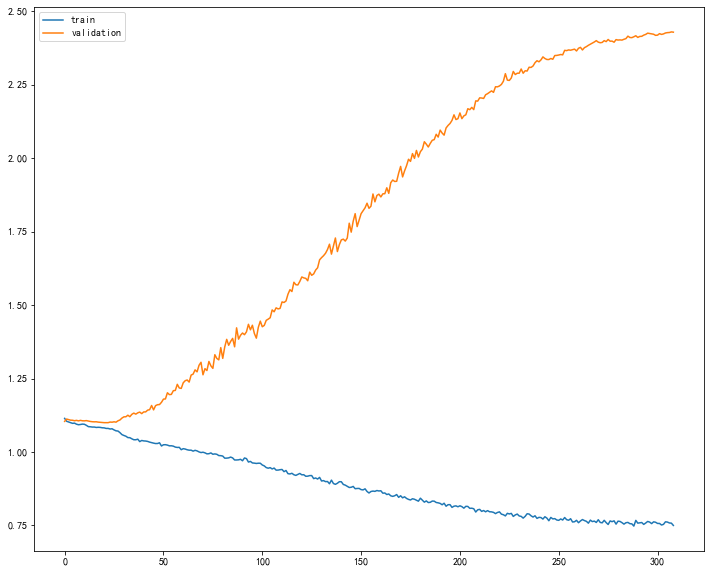

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_43 (GRU)                 (None, 30, 64)            15744     
_________________________________________________________________
dropout_55 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
gru_44 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 3)                 99        
Total params: 25,251
Trainable params: 25,251
Non-trainable params: 0
_________________________________________________________________
None


In [995]:
model,history= basic_lstm(input_dim, feature_size)
model.save('./saveModel/GRU_3to1.h5')
print(model.summary())


In [996]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc', 'lr'])

In [997]:
acc = history_dict['accuracy']

In [998]:
acc

[0.40545454621315,
 0.3672727346420288,
 0.3545454442501068,
 0.36441558599472046,
 0.3646753132343292,
 0.3677922189235687,
 0.3659740388393402,
 0.37844157218933105,
 0.3774026036262512,
 0.3729870021343231,
 0.37142857909202576,
 0.39012986421585083,
 0.39324674010276794,
 0.4025973975658417,
 0.3929870128631592,
 0.401818186044693,
 0.3984415531158447,
 0.4012987017631531,
 0.4025973975658417,
 0.4057142734527588,
 0.4036363661289215,
 0.40857142210006714,
 0.4124675393104553,
 0.41428571939468384,
 0.4106493592262268,
 0.41350650787353516,
 0.41740259528160095,
 0.42493507266044617,
 0.4376623332500458,
 0.4477922022342682,
 0.4431168735027313,
 0.4490908980369568,
 0.45376622676849365,
 0.4574025869369507,
 0.4641558527946472,
 0.45636364817619324,
 0.46207791566848755,
 0.4618181884288788,
 0.4745454490184784,
 0.45896103978157043,
 0.46701300144195557,
 0.4654545485973358,
 0.4631168842315674,
 0.47740259766578674,
 0.47090908885002136,
 0.47792208194732666,
 0.4753246605396271

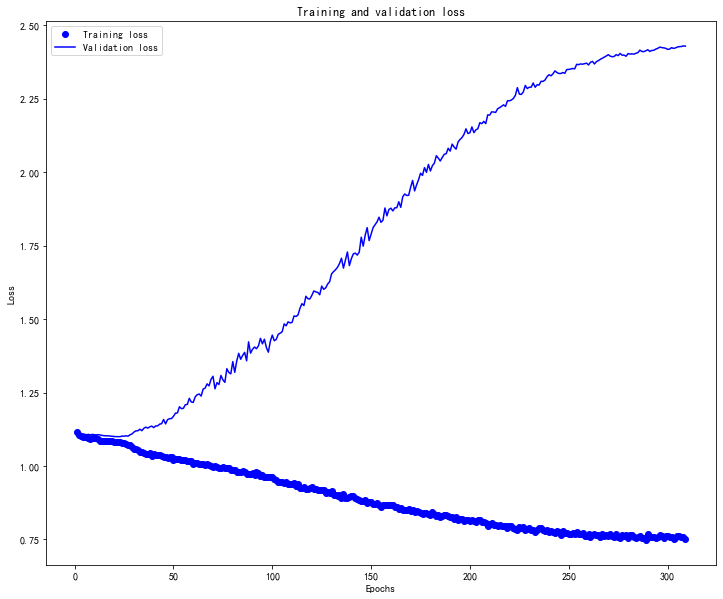

In [999]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

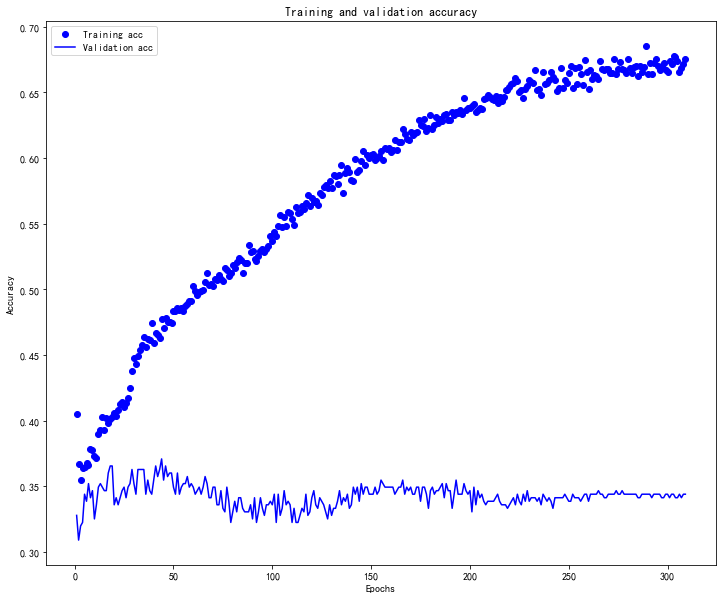

In [1000]:
plt.clf()   # 清除数字
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [1001]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [1002]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

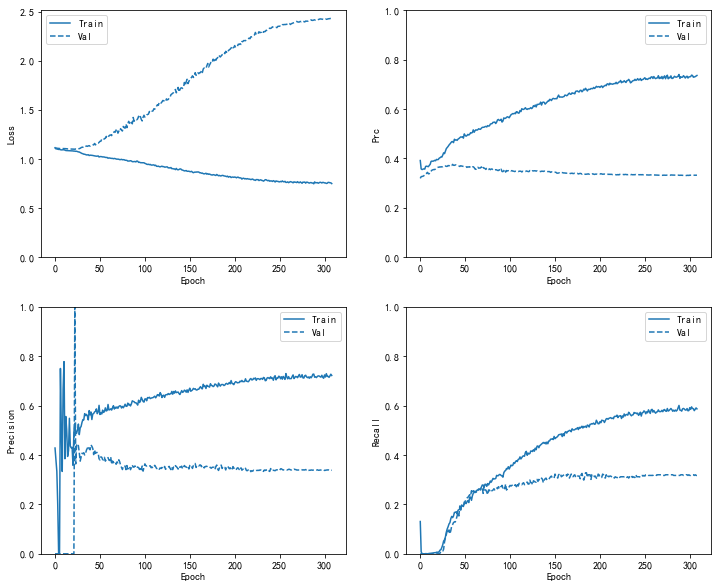

In [1003]:
plot_metrics(history)

### Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics 
### You can use a confusion matrix to summarize the actual vs. predicted labels where the X axis is the predicted label  and the Y axis is the actual label.

In [1004]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [1005]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

#plot_cm(y_test, test_predictions_baseline)

loss :  2.1061151027679443
tp :  280.0
fp :  398.0
tn :  1092.0
fn :  465.0
accuracy :  0.4040268361568451
precision :  0.4129793643951416
recall :  0.3758389353752136
auc :  0.5629732012748718
prc :  0.40610599517822266



# 绘制ROC曲线

In [1006]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.preprocessing import label_binarize


In [1007]:
#同时也是分类得分y_score
#概率矩阵P和标签矩阵L分别对应代码中的y_score和y_one_hot：
yhat = model.predict(X_test, verbose=0)


In [1008]:
from sklearn.preprocessing import label_binarize


In [1009]:
y_test

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [1010]:
yhat

array([[3.4704331e-02, 2.1883947e-01, 7.4645615e-01],
       [1.3592567e-02, 1.4131990e-01, 8.4508759e-01],
       [1.1906686e-03, 2.0399762e-02, 9.7840959e-01],
       ...,
       [4.1766610e-04, 1.3065566e-02, 9.8651683e-01],
       [5.1289517e-04, 1.8356465e-02, 9.8113060e-01],
       [7.5982051e-04, 3.2208983e-02, 9.6703124e-01]], dtype=float32)

调用函数auc： 0.5633223728660871
手动计算auc： 0.5633223728660871


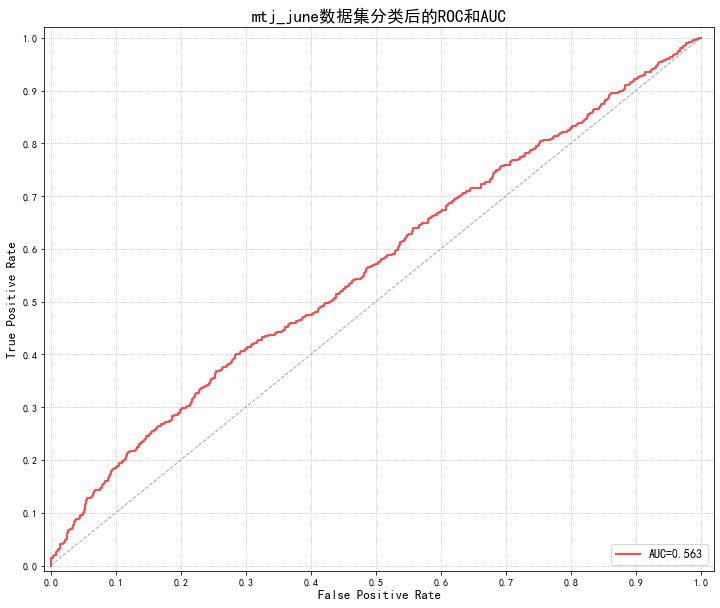

In [1011]:
# 计算属于各个类别的概率，返回值的shape = [n_samples, n_classes]
y_score = model.predict(X_test)
# 1、调用函数计算micro类型的AUC
print('调用函数auc：', metrics.roc_auc_score(y_test, y_score, average='micro'))
# 2、手动计算micro类型的AUC
#首先将矩阵y_one_hot和y_score展开，然后计算假正例率FPR和真正例率TPR
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(),y_score.ravel())
auc = metrics.auc(fpr, tpr)
print('手动计算auc：', auc)
#绘图
mpl.rcParams['font.sans-serif'] = u'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
#FPR就是横坐标,TPR就是纵坐标
plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'mtj_june数据集分类后的ROC和AUC', fontsize=17)
plt.show()

In [1012]:
dict_count = {}
dict_count['跌']=0
dict_count['涨']=0
dict_count['平']=0
for i in range(len(y_train)):
    if(y_train[i][0] ==1):
        dict_count['跌'] += 1
    if(y_train[i][1] == 1):
        dict_count['平'] += 1
    if(y_train[i][2] == 1):
        dict_count['涨'] += 1

In [1013]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
def to_0_1(y):
    res = []
    for i in range(y.shape[0]):
        if(y[i][0] > y[i][1] and y[i][0] > y[i][2]):
            res.append(-1) #跌
        if(y[i][1] > y[i][0] and y[i][1] > y[i][2]):
            res.append(0) #平
        if(y[i][2] > y[i][0] and y[i][2] > y[i][1]):
            res.append(1) #涨
    return np.array(res)

def result_to_0_1(y):
        if(tf.is_tensor(y)):
            y = y.numpy()
            for i in range(y.shape[0]):
                max_index = 0
                if(y[i][max_index] < y[i][1]):
                    max_index = 1
                if(y[i][max_index] < y[i][2]):
                    max_index = 2
                list_temp = [0,1,2]
                list_temp.pop(max_index)
                y[i][max_index] = 1
                y[i][list_temp[0]] = 0
                y[i][list_temp[1]] = 0
        else:
            for i in range(y.shape[0]):
                max_index = 0
                if(y[i][max_index] < y[i][1]):
                    max_index = 1
                if(y[i][max_index] < y[i][2]):
                    max_index = 2
                list_temp = [0,1,2]
                list_temp.pop(max_index)
                y[i][max_index] = 1
                y[i][list_temp[0]] = 0
                y[i][list_temp[1]] = 0
        return y

In [1014]:
y = result_to_0_1(yhat)

In [1015]:
y_pre = to_0_1(yhat)
y_true = to_0_1(y_test)

In [1016]:
y_pre

array([ 1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  0, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0, -1,  1,  1,  1,
        1,  1,  1,  1,  1

In [1017]:
y_true

array([-1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1,  0, -1, -1,  0,
        1,  0,  1,  1,  1, -1, -1,  1, -1,  0,  1, -1, -1,  1,  1, -1, -1,
       -1,  1,  1, -1,  1,  0,  1,  1,  1, -1,  1,  1,  0,  1, -1,  1,  1,
        0,  1,  0, -1,  1, -1,  0,  0,  1,  1,  0,  1,  1,  0, -1,  0, -1,
        1, -1, -1, -1,  0,  1, -1,  0,  0,  1, -1,  1,  0,  1, -1,  1, -1,
        1, -1,  1, -1,  1,  1, -1,  1,  1,  0, -1, -1,  1,  0,  0, -1,  0,
       -1, -1,  0,  1, -1,  0,  1,  0,  1, -1, -1,  1,  1,  1,  0,  0,  1,
        0,  1,  1,  1,  1,  1,  0,  1, -1,  1,  0,  1,  0,  0, -1,  0,  1,
        0,  0,  1,  1,  1,  0,  0,  0,  1, -1,  0, -1,  0,  0,  0,  0,  1,
        0,  1,  0,  0, -1, -1,  0,  0,  0,  0, -1, -1,  1, -1, -1,  1,  0,
       -1,  0,  1,  0, -1, -1,  1,  0, -1,  0,  0,  0,  1,  0,  0,  1, -1,
        0,  0,  1,  0,  1,  0, -1,  1,  1,  0, -1, -1, -1,  0,  0, -1, -1,
       -1,  1,  0, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  0,  0,  1,
       -1, -1,  0,  1, -1

In [1018]:
cm = confusion_matrix(y_true, y_pre)
conf_matrix = pd.DataFrame(cm, index=['涨','平','跌'], columns=['涨','平','跌'])

In [1019]:
cm

array([[ 59,  16, 171],
       [ 52,   7, 130],
       [ 53,  22, 235]], dtype=int64)

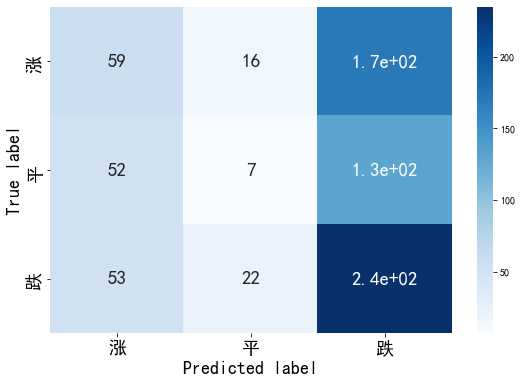

In [1020]:
# plot size setting
fig, ax = plt.subplots(figsize = (9,6))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 19}, cmap="Blues")
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('confusion.pdf', bbox_inches='tight')
plt.show()

In [1021]:
dict_count = {}
dict_count['跌']=0
dict_count['涨']=0
dict_count['平']=0
for i in range(len(y_test)):
    if(y_train[i][0] ==1):
        dict_count['跌'] += 1
    if(y_train[i][1] == 1):
        dict_count['平'] += 1
    if(y_train[i][2] == 1):
        dict_count['涨'] += 1
        


In [1022]:
dict_count

{'跌': 314, '涨': 293, '平': 138}

In [1023]:
print('------Weighted------')
print('Weighted precision', precision_score(y_true, y_pre, average='weighted'))
print('Weighted recall', recall_score(y_true, y_pre, average='weighted'))
print('Weighted f1-score', f1_score(y_true, y_pre, average='weighted'))
print('------Macro------')
print('Macro precision', precision_score(y_true, y_pre, average='macro'))
print('Macro recall', recall_score(y_true, y_pre, average='macro'))
print('Macro f1-score', f1_score(y_true, y_pre, average='macro'))
print('------Micro------')
print('Micro precision', precision_score(y_true, y_pre, average='micro'))
print('Micro recall', recall_score(y_true, y_pre, average='micro'))
print('Micro f1-score', f1_score(y_true, y_pre, average='micro'))

------Weighted------
Weighted precision 0.34069017329460083
Weighted recall 0.4040268456375839
Weighted f1-score 0.34138243561062354
------Macro------
Macro precision 0.3179148296458089
Macro recall 0.34497965051335094
Macro f1-score 0.30106316447779863
------Micro------
Micro precision 0.4040268456375839
Micro recall 0.4040268456375839
Micro f1-score 0.4040268456375839


<ipython-input-1024-72ed8574a92e>:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


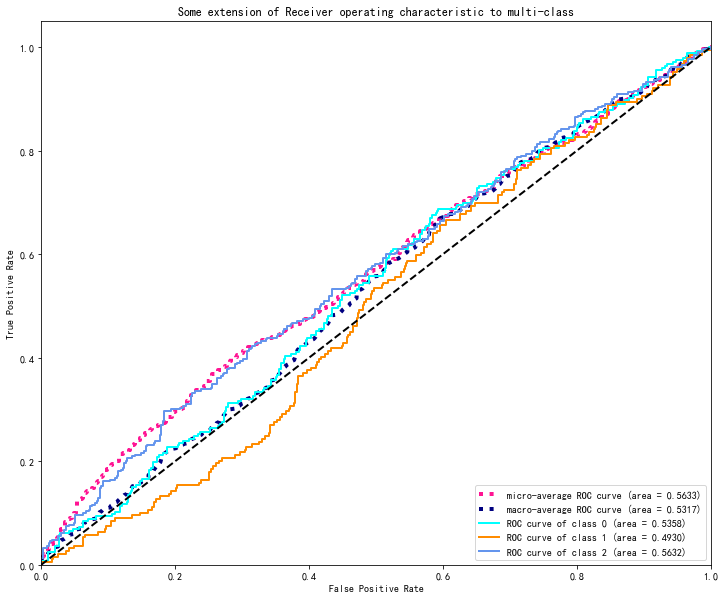

In [1024]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# 计算每一类的ROC

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]) )

plt.plot([0, 1], [0, 1], 'k--', lw=lw )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [1025]:
tp = pd.DataFrame()
tp['CS'] = yhat.tolist()

In [1026]:
tp.describe()

,CS
count,745
unique,3
top,"[0.0, 0.0, 1.0]"
freq,536


In [1027]:
yhat.shape

(745, 3)